# 0.0 Imports

In [1]:
import warnings
import pandas as pd
import sweetviz as sv
import seaborn as sns

from tabulate import tabulate
from matplotlib import pyplot as plt
from pycorrcat import pycorrcat

## 0.1 Load data

In [2]:
feature_engineering = catalog.load("feature_engineering")

[09/24/23 13:06:46] INFO     Loading data from 'feature_engineering' (CSVDataSet)...            ]8;id=913835;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=819927;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#492\492]8;;\

## 0.2 Helper Functions

In [3]:
def notebook_settings():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', 60)
    pd.set_option('display.float_format', lambda x: '%.3f' % x)

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    sns.set()
    warnings.filterwarnings('ignore')
    return None


notebook_settings()

# 4.0 Exploratory Data Analysis

In [4]:
exploratory_data_analysis = feature_engineering.copy()

exploratory_data_analysis.head()

,rank,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.490,29.020,3.770,8.460,82.740
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.080,3.580,6.810,0.770,40.240
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.850,12.880,3.790,3.310,35.820
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.750,11.010,3.280,2.960,33.000
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.270,8.890,10.220,1.000,31.370


## 4.1 Univariate Analysis

It is not necessary to execute the code, you can check the result in `/docs/SWEETVIZ_REPORT.html`.

In [46]:
# We will use sweetviz for univariate automated analysis
my_report = sv.analyze(exploratory_data_analysis)
my_report.show_html(filepath='../docs/SWEETVIZ_REPORT.html', layout='widescreen')

                                             |          | [  0%]   00:00 -> (? left)

Report ../docs/SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### 4.1.1 Sweetviz's main analyses

Sweetviz is a powerful tool for automating analysis. The result is made up of several graphs which can be overwhelming to consult. For now, I'm highlighting the main information extracted, but it would be interesting to enrich this session with graphs in a second version:
- There are repeated game names, which may be plausible due to the various releases on different platforms; a second version could contain an analysis of this premise.
- There is a trend of increasing number of releases, which validates the initial premise of the problem where the gaming market is constantly growing, however there was a considerable decline after 2010 and as the data corresponds until 2020 it would not justify a potential "lack of data".

### 4.1.2 Response Variable

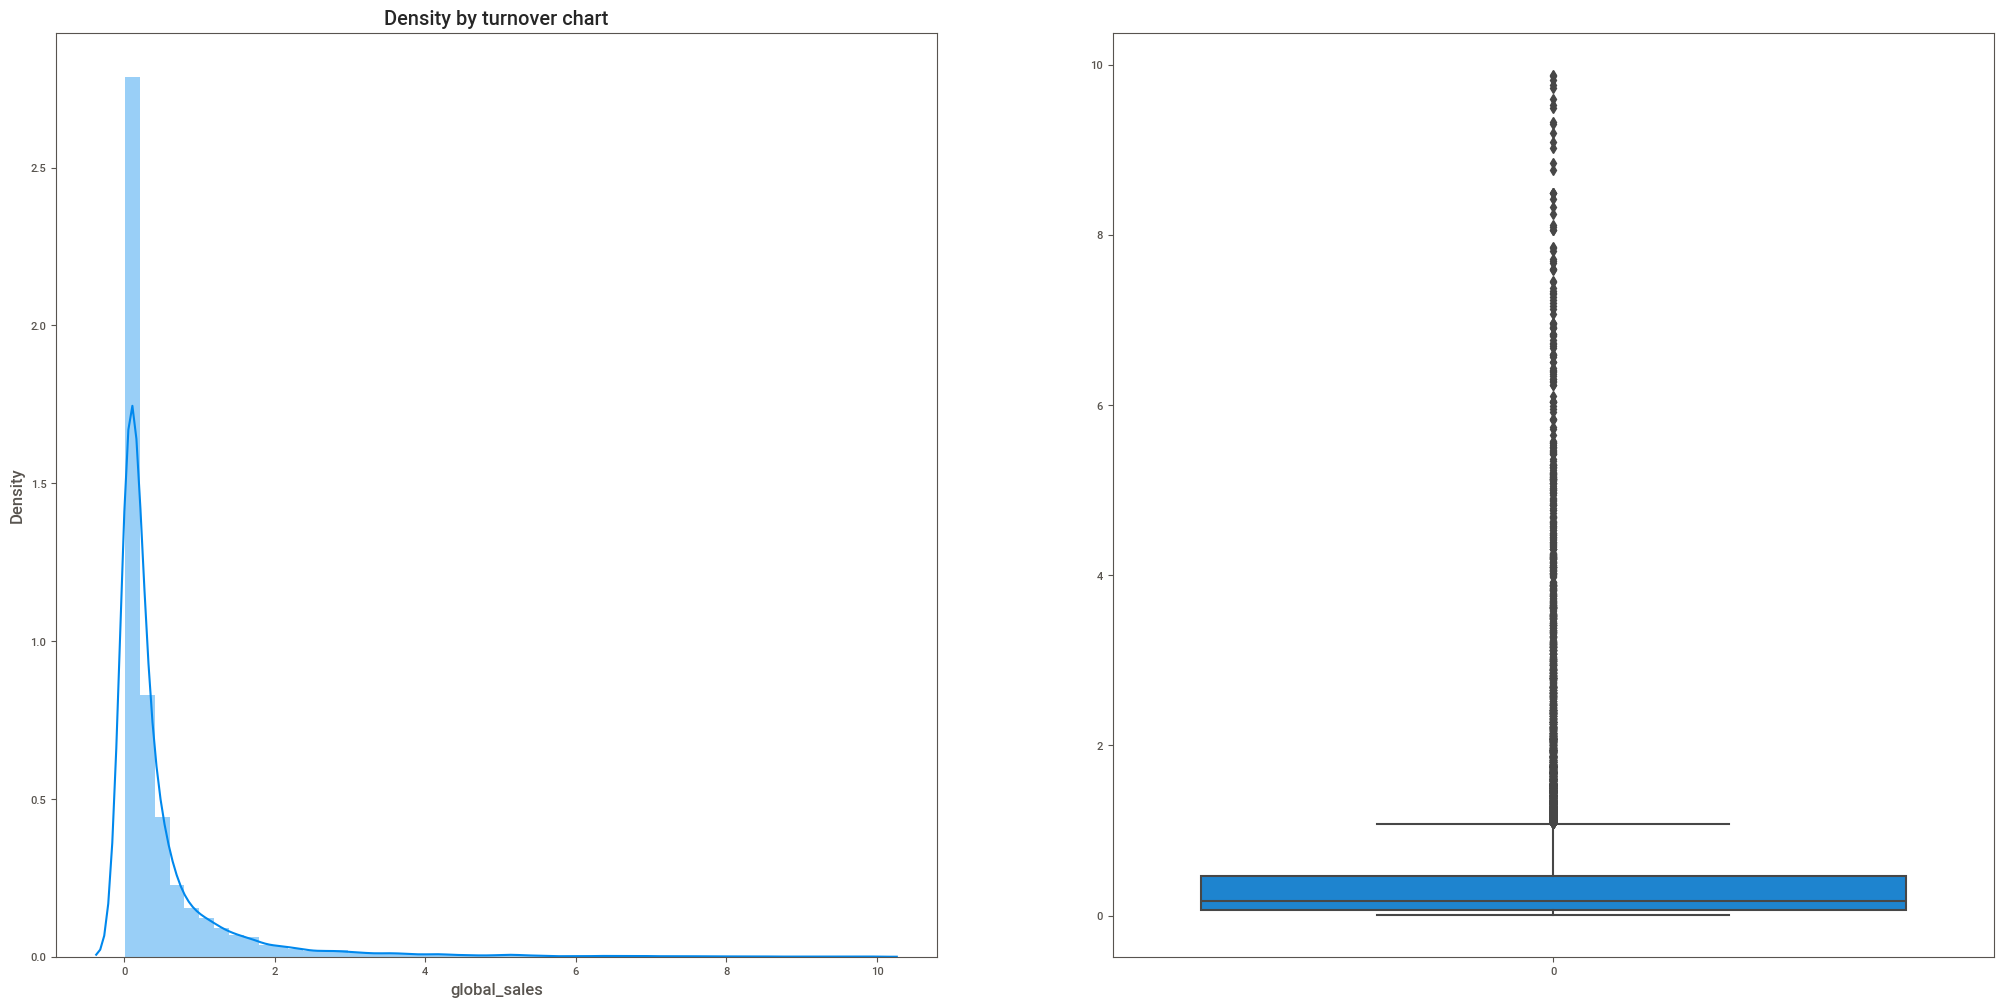

In [47]:
df_aux = exploratory_data_analysis[exploratory_data_analysis['global_sales'] < 10].reset_index(drop=True)

plt.subplot(1, 2, 1)
plt.title('Density by turnover chart')
sns.distplot(df_aux['global_sales'], kde=True)

plt.subplot(1, 2, 2)
sns.boxplot(df_aux['global_sales']);

Here we can validate a premise of the descriptive analysis where sales follow the Poisson distribution with the large presence of outliers.

### 4.1.3 Analysis of Video Games Sales Trends

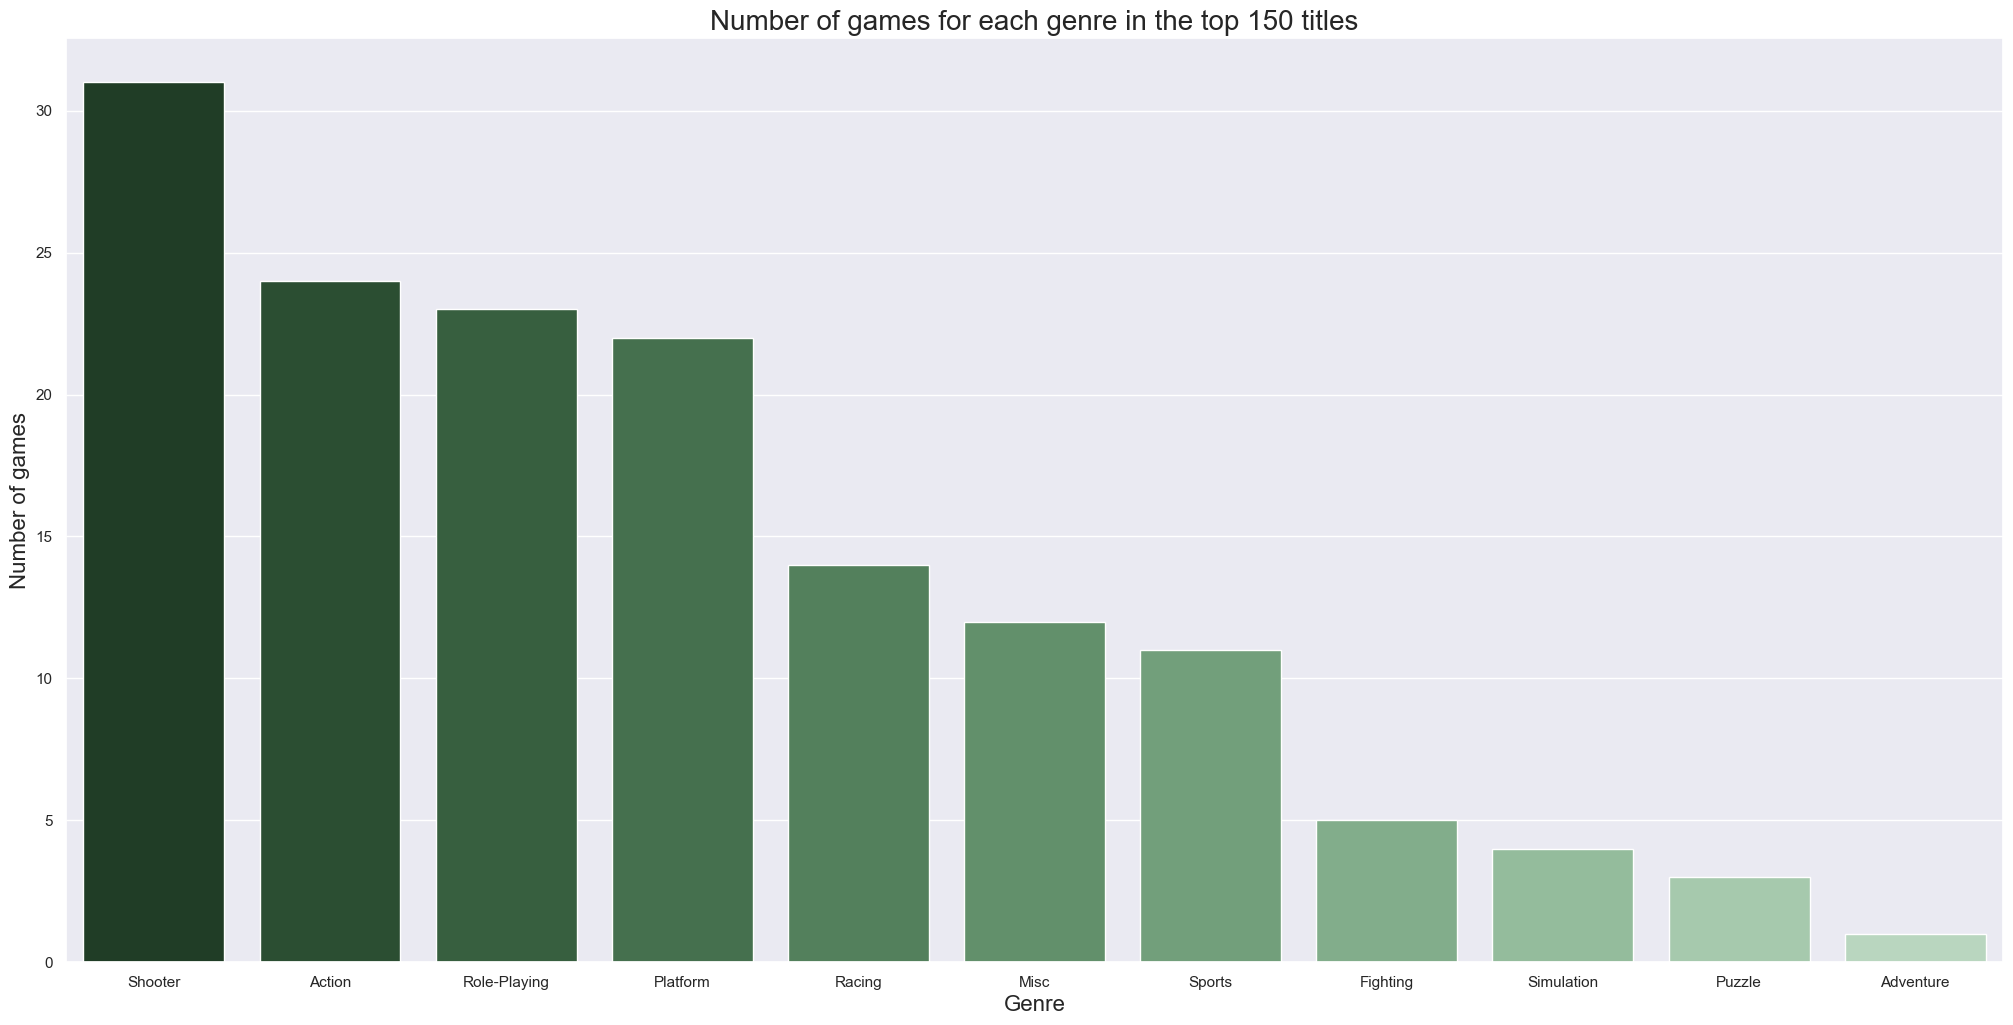

In [15]:
# Histogram of how many games each genre has in the top 150 titles of the rank
# For the categorical situation, a countplot makes more sense, plus we can sort 
#and represent the quantity by genre by gradient

top_150 = exploratory_data_analysis.sort_values(by='rank').head(150)
ordered_genres = top_150['genre'].value_counts().index

# Create a gradient color palette
n_colors = len(ordered_genres)
cmap = sns.cubehelix_palette(n_colors=n_colors, start=2, rot=0, dark=0.2, light=0.8, reverse=True)

sns.countplot(data=top_150, x='genre', order=ordered_genres, palette=cmap)
plt.title("Number of games for each genre in the top 150 titles", fontsize=20)
plt.ylabel("Number of games", fontsize=16)
plt.xlabel("Genre", fontsize=16)
plt.show()

Reference: [Nintendo consoles](https://pt.wikipedia.org/wiki/Nintendo#Consoles)

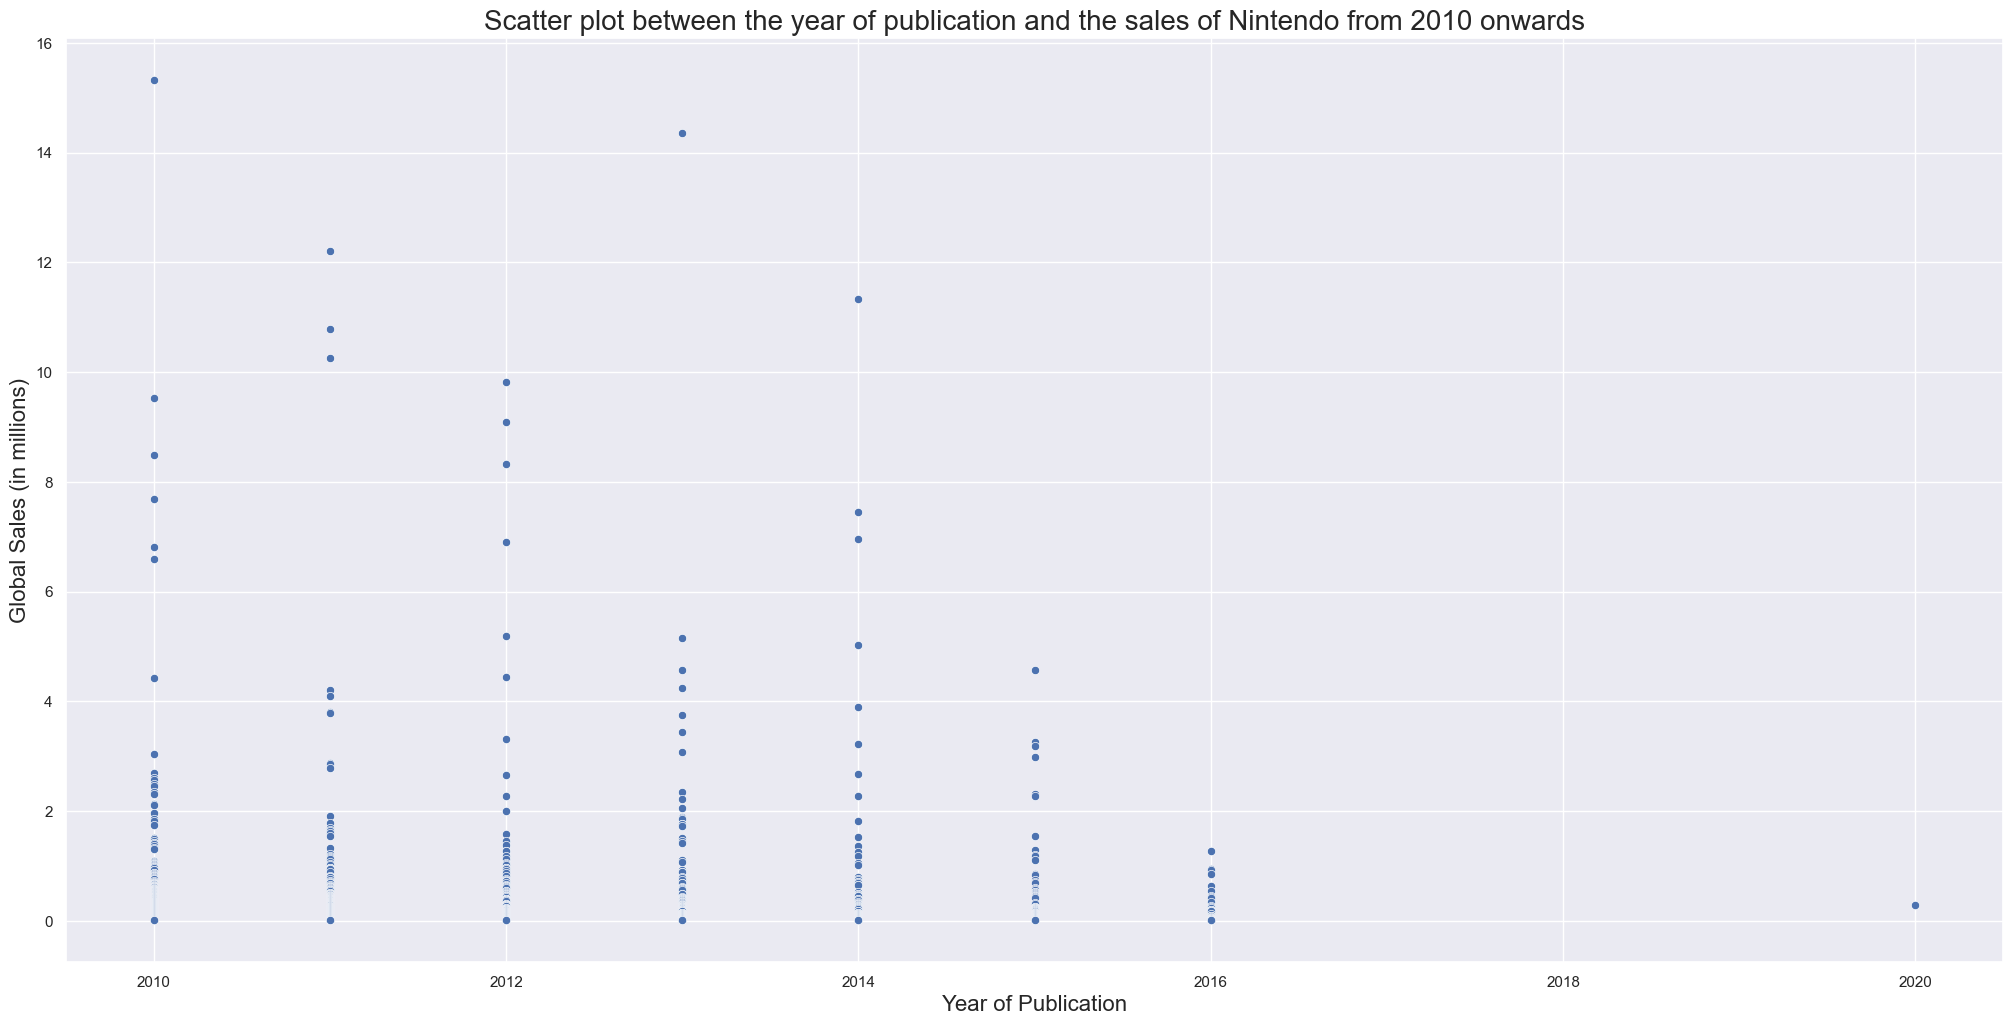

In [6]:
# Scatter plot between the year of publication and the sales of Nintendo from 2010 onwards
# Identify Nintendo platforms from our dataset (like Wii, WiiU, DS, 3DS)
nintendo_platforms = ['Wii', 'NES', 'GB', 'SNES', 'GBA', 'N64', 'GC', 'WiiU', 'DS', '3DS']

nintendo_sales = exploratory_data_analysis[(exploratory_data_analysis['platform'].isin(nintendo_platforms)) & (exploratory_data_analysis['year'] >= 2010)]
sns.scatterplot(data=nintendo_sales, x='year', y='global_sales', palette='set3')
plt.title("Scatter plot between the year of publication and the sales of Nintendo from 2010 onwards", fontsize=20)
plt.ylabel("Global Sales (in millions)", fontsize=16)
plt.xlabel("Year of Publication", fontsize=16);

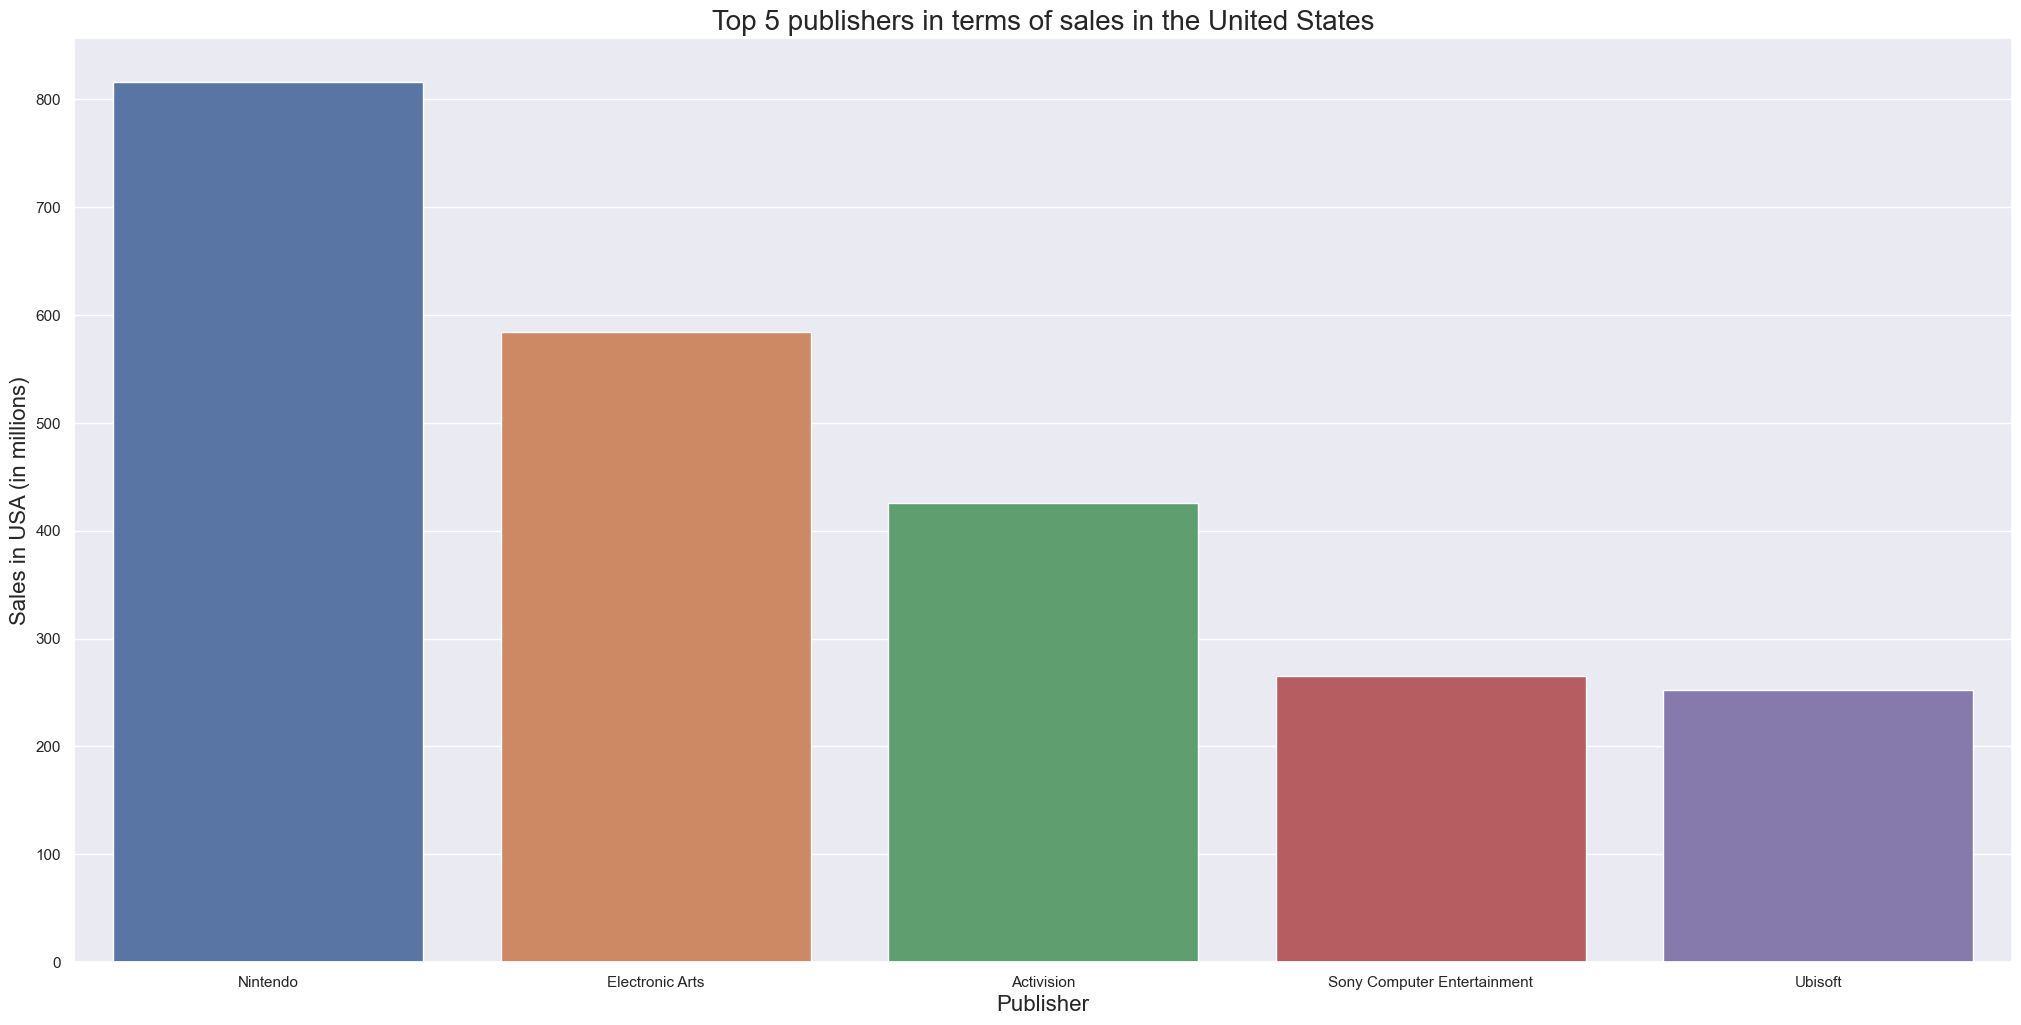

In [7]:
# The top 5 publishers in terms of sales in the United States
top_publishers = exploratory_data_analysis.groupby('publisher')['na_sales'].sum().nlargest(5)
sns.barplot(x=top_publishers.index, y=top_publishers.values)
plt.title("Top 5 publishers in terms of sales in the United States", fontsize=20)
plt.ylabel("Sales in USA (in millions)", fontsize=16)
plt.xlabel("Publisher", fontsize=16);

## 4.2 Bivariate Analysis

### 1. Hypothesis: Action games have a sales median that's 10% higher than RPG games in the European market.

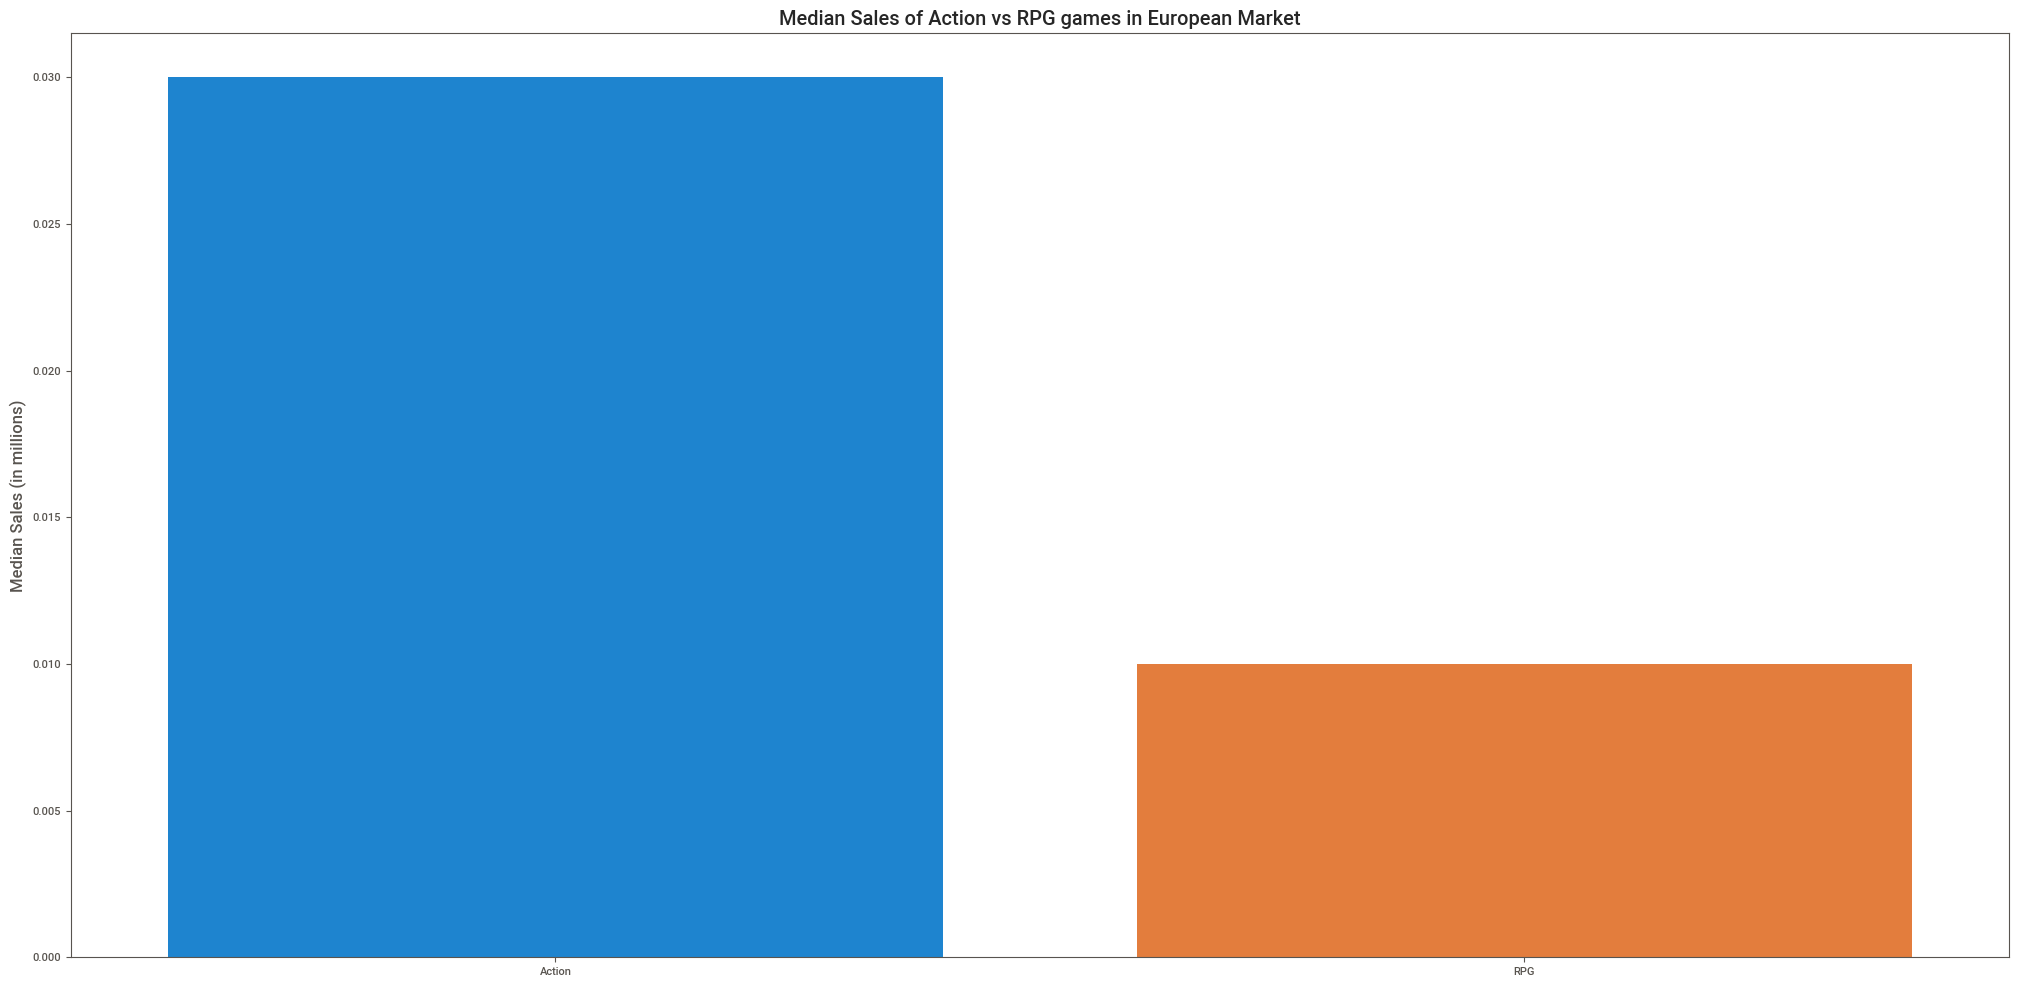

In [51]:
action_games = exploratory_data_analysis[exploratory_data_analysis['genre'] == 'Action']
rpg_games = exploratory_data_analysis[exploratory_data_analysis['genre'] == 'Role-Playing']

# Calculate the median sales for both genres in the European market
medians = {
    'Action': action_games['eu_sales'].median(),
    'RPG': rpg_games['eu_sales'].median()
}

sns.barplot(x=list(medians.keys()), y=list(medians.values()))
plt.ylabel('Median Sales (in millions)')
plt.title('Median Sales of Action vs RPG games in European Market')
plt.show();

### 2. Hypothesis: Strategy games have 15% higher sales on PC platforms compared to sony platforms in the North American market.

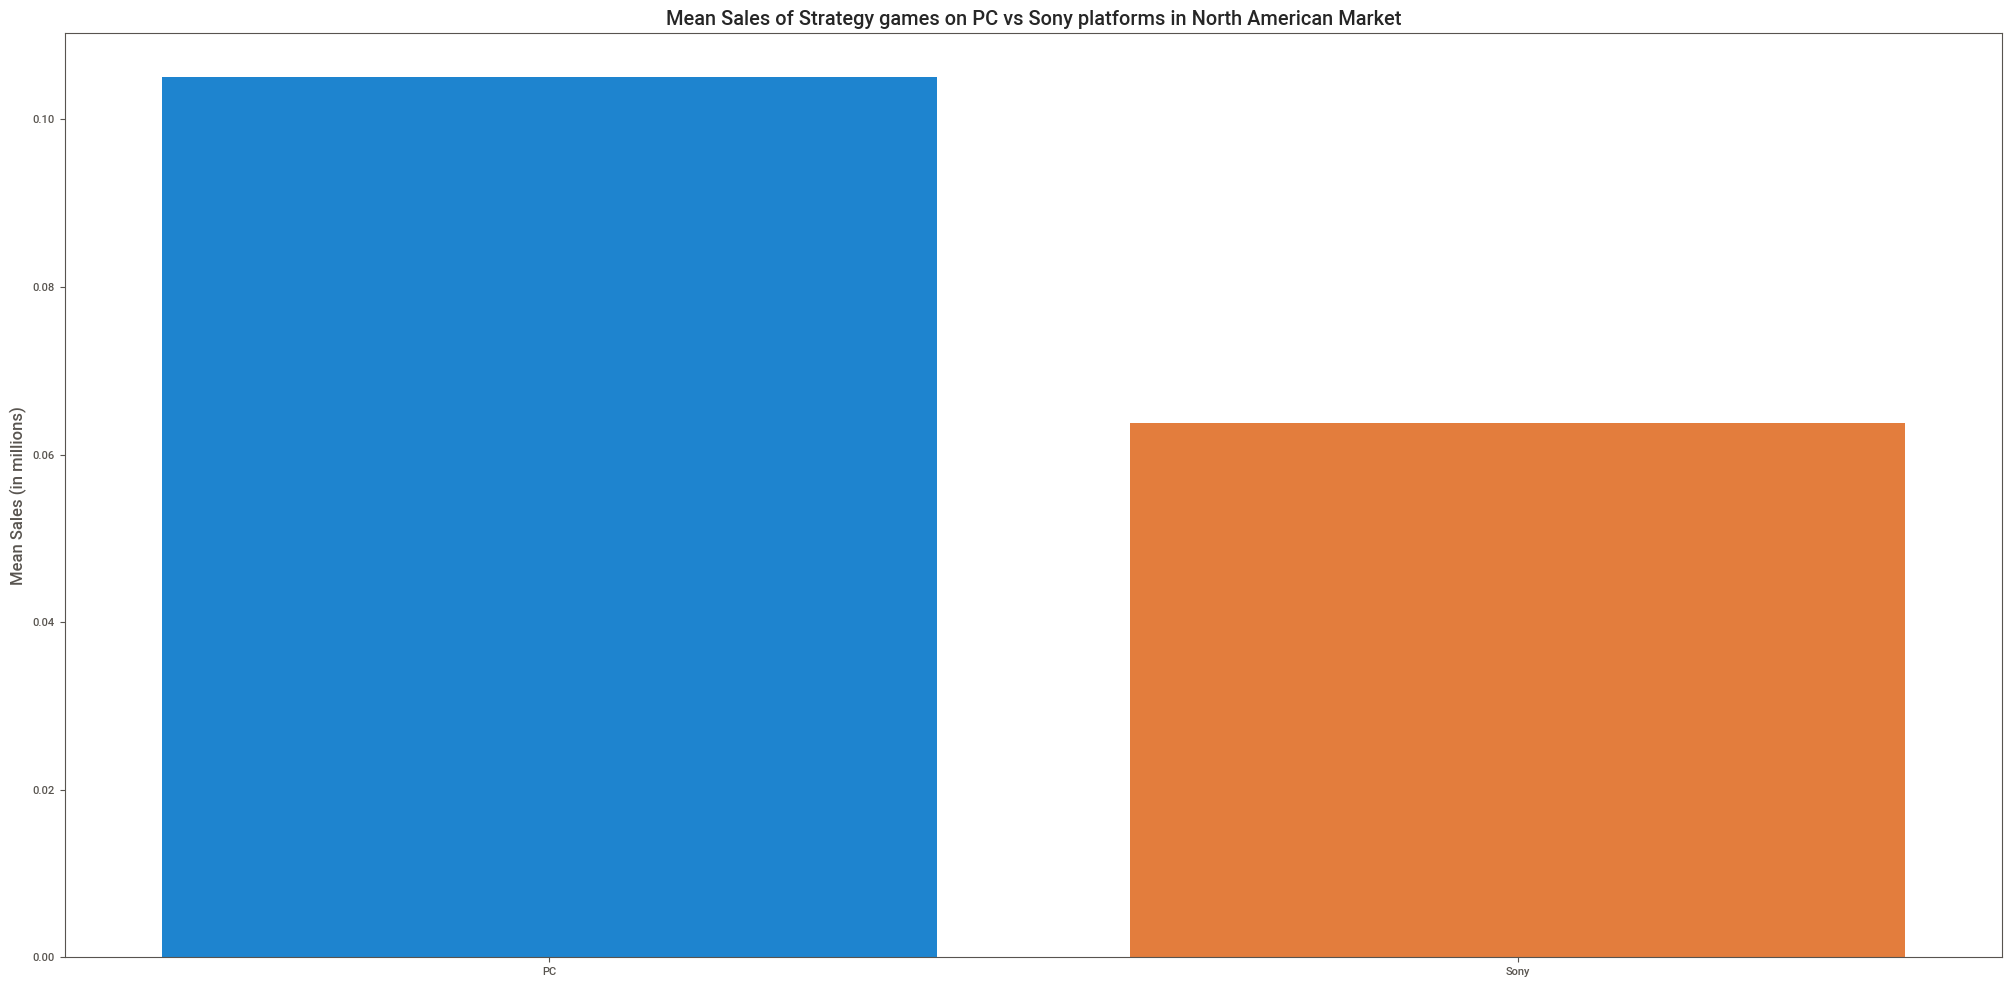

In [52]:
strategy_games = exploratory_data_analysis[exploratory_data_analysis['genre'] == 'Strategy']

# Identify Sony platforms from our dataset (like PS2, PS3, PS4, etc.)
sony_platforms = [platform for platform in strategy_games['platform'].unique() if 'PS' in platform]

# Calculate the mean sales for Strategy games on PC and Sony platforms in the North American market
means = {
    'PC': strategy_games[strategy_games['platform'] == 'PC']['na_sales'].mean(),
    'Sony': strategy_games[strategy_games['platform'].isin(sony_platforms)]['na_sales'].mean()
}

sns.barplot(x=list(means.keys()), y=list(means.values()))
plt.ylabel('Mean Sales (in millions)')
plt.title('Mean Sales of Strategy games on PC vs Sony platforms in North American Market')
plt.show();

### 3. Hypothesis: Adventure games released on microsoft and sony consoles see a 10% increase in overall sales in the European market compared to those released on PC.

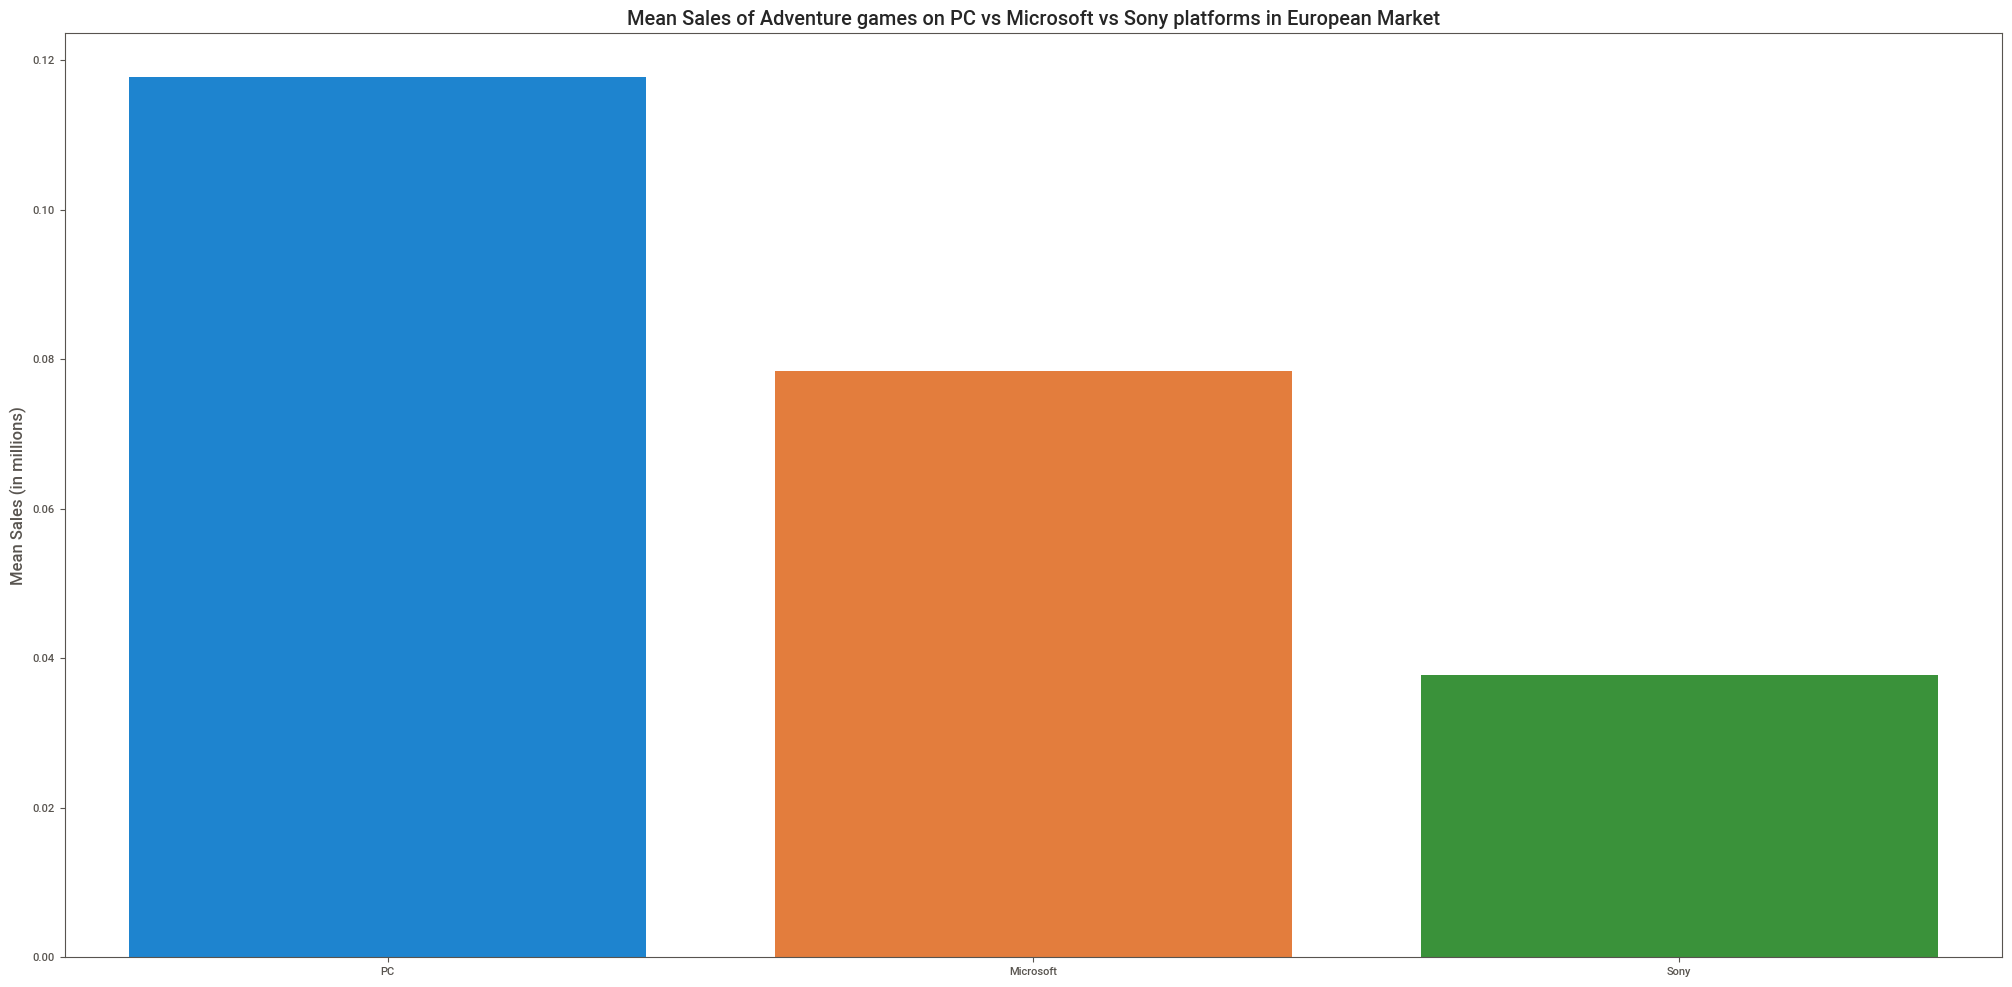

In [53]:
adventure_games = exploratory_data_analysis[exploratory_data_analysis['genre'] == 'Adventure']

# Identify Microsoft platforms from our dataset (like X360, XB, XOne)
microsoft_platforms = ['X360', 'XB', 'XOne']

# Calculate the mean sales for Adventure games on PC, Microsoft, and Sony platforms in the European market
means_adventure = {
    'PC': adventure_games[adventure_games['platform'] == 'PC']['eu_sales'].mean(),
    'Microsoft': adventure_games[adventure_games['platform'].isin(microsoft_platforms)]['eu_sales'].mean(),
    'Sony': adventure_games[adventure_games['platform'].isin(sony_platforms)]['eu_sales'].mean()
}

sns.barplot(x=list(means_adventure.keys()), y=list(means_adventure.values()))
plt.ylabel('Mean Sales (in millions)')
plt.title('Mean Sales of Adventure games on PC vs Microsoft vs Sony platforms in European Market')
plt.show();

### 4. Hypothesis: PC games have a sales mean that's 15% higher than nintendo console games in the North American market.

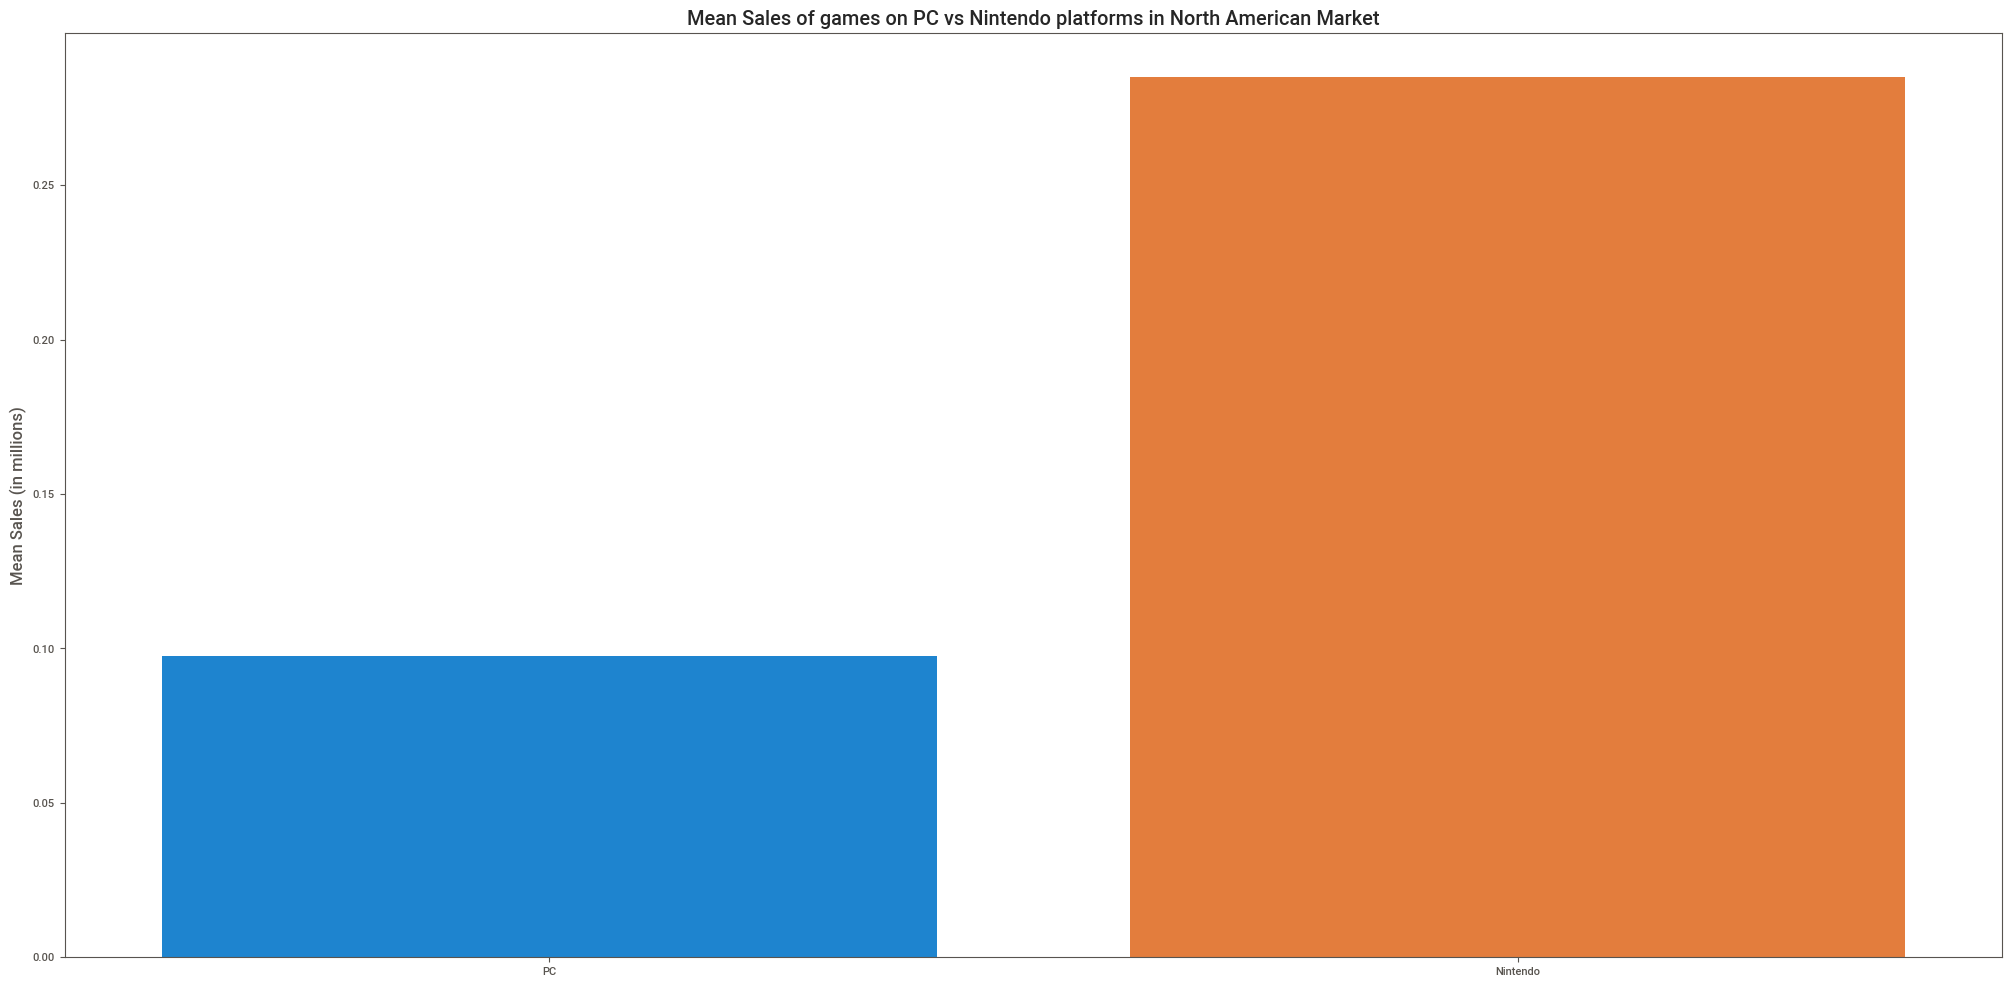

In [54]:
# Calculate the mean sales for games on PC and Nintendo platforms in the North American market
means_pc_nintendo = {
    'PC': exploratory_data_analysis[exploratory_data_analysis['platform'] == 'PC']['na_sales'].mean(),
    'Nintendo': exploratory_data_analysis[exploratory_data_analysis['platform'].isin(nintendo_platforms)]['na_sales'].mean()
}

sns.barplot(x=list(means_pc_nintendo.keys()), y=list(means_pc_nintendo.values()))
plt.ylabel('Mean Sales (in millions)')
plt.title('Mean Sales of games on PC vs Nintendo platforms in North American Market')
plt.show();

### 5. Hypothesis: Games published by Electronic Arts have a sales average that's 25% higher than those published by Ubisoft in the Japan market.

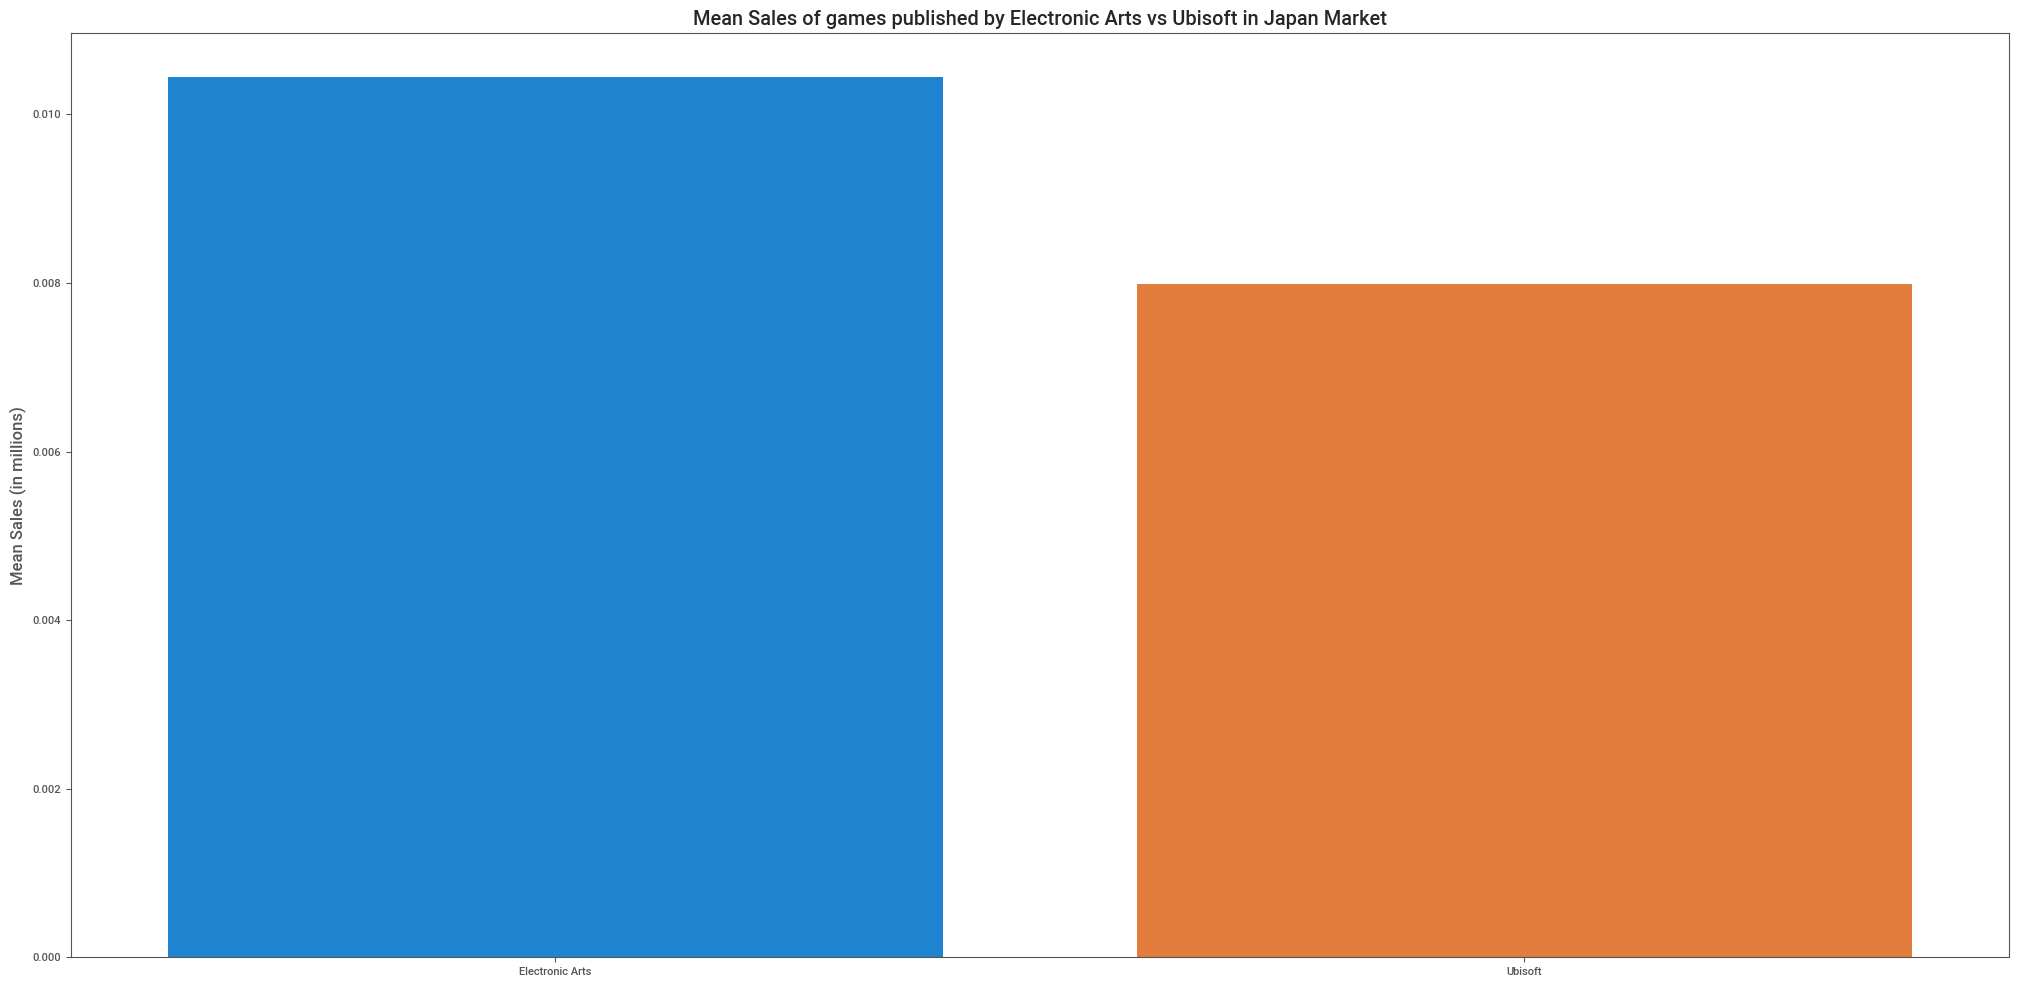

In [55]:
ea_games = exploratory_data_analysis[exploratory_data_analysis['publisher'] == 'Electronic Arts']
ubisoft_games = exploratory_data_analysis[exploratory_data_analysis['publisher'] == 'Ubisoft']

# Calculate the mean sales for both publishers in the Japan market
means_publishers = {
    'Electronic Arts': ea_games['jp_sales'].mean(),
    'Ubisoft': ubisoft_games['jp_sales'].mean()
}

sns.barplot(x=list(means_publishers.keys()), y=list(means_publishers.values()))
plt.ylabel('Mean Sales (in millions)')
plt.title('Mean Sales of games published by Electronic Arts vs Ubisoft in Japan Market')
plt.show();

### 4.2.1 Summary of Hypotheses

In [56]:
tab = [['Hypothesis', 'Conclusion'],
       ['H1', 'True'],
       ['H2', 'False'],
       ['H3', 'False'],
       ['H4', 'False'],
       ['H5', 'False'],
      ]
print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion
------------  ------------
H1            True
H2            False
H3            False
H4            False
H5            False


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

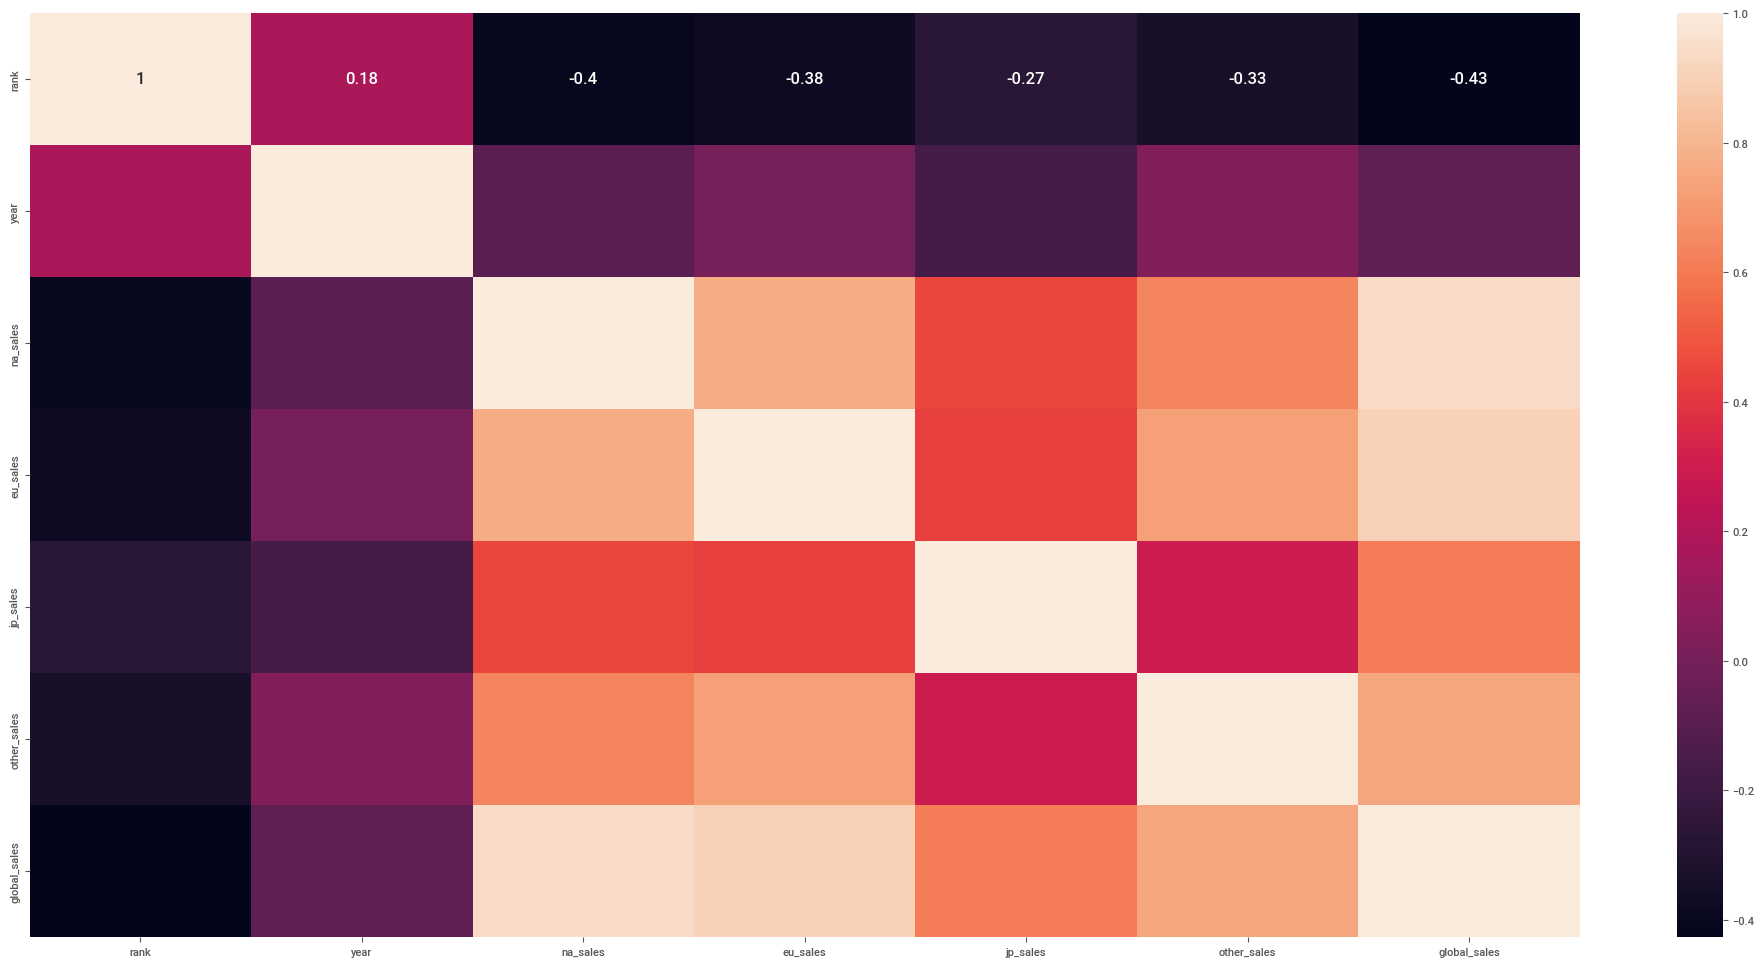

In [57]:
num_attributes = exploratory_data_analysis.select_dtypes(include='number')

correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

- The correlation in sales may indicate a premise where the success of a game tends to be a success in all regions even if the market is independent.

### 4.3.2 Categorical Attributes

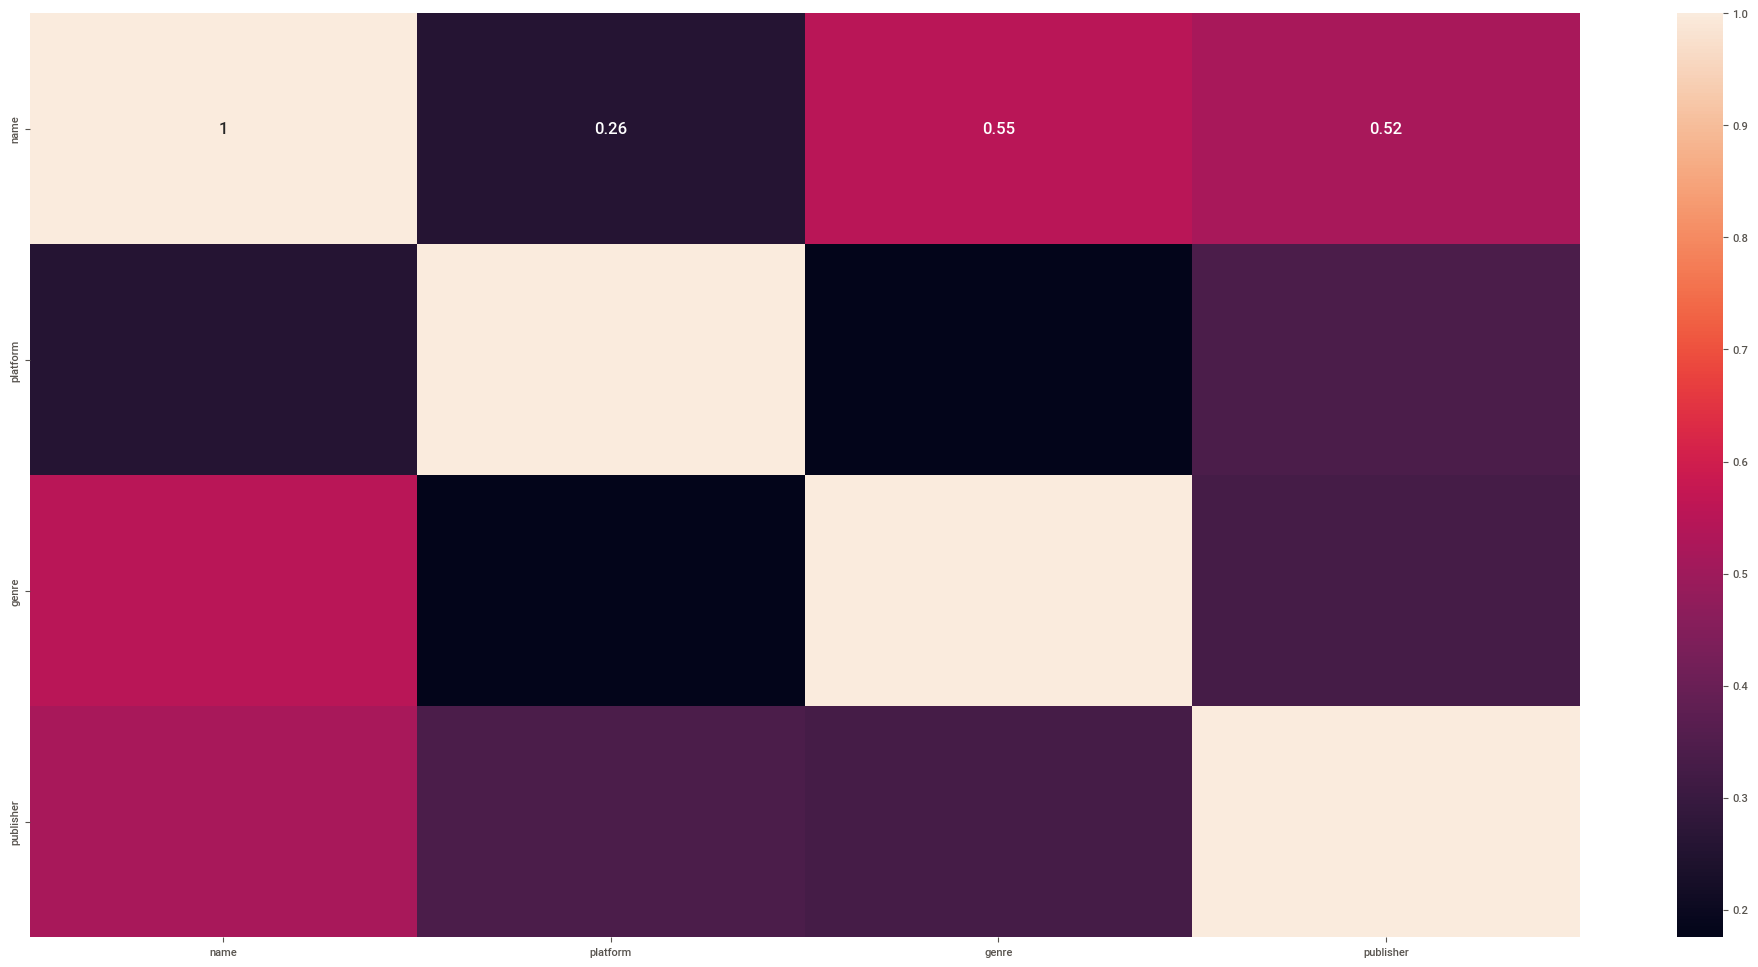

In [58]:
# only categorical data
cat_attributes = exploratory_data_analysis.select_dtypes(include='object')

# Cramer V correlation
correlation = pycorrcat.corr_matrix(cat_attributes, list(cat_attributes.columns))
sns.heatmap(correlation, annot=True);

In [59]:
catalog.save("exploratory_data_analysis", exploratory_data_analysis)

[09/21/23 23:03:34] INFO     Saving data to 'exploratory_data_analysis' (CSVDataSet)...         ]8;id=481686;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=923505;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#531\531]8;;\